# CIAN sales data 2018-2021 Exploratory Data Analysis

In [1]:
# first, let's import our libraties

import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# dataset is in CSV file that located in the same directory with this notebook

PATH = 'cian-sales-2018-2021.csv'
df = pd.read_csv(PATH)
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [3]:
# the dataset has no null values

df.isna().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [3]:
# let's check full duplicates

df.duplicated().sum()

1523

In [3]:
# drop the duplicates we found

df = df.drop_duplicates()

In [5]:
# Verifying the df and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5475483 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 584.8+ MB


In [7]:
# basic data exploration in proper format

df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) 

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000
mean,4421478.23207,54.03784,53.24654,4307.44040,1.94903,6.21382,11.39749,1.72621,53.91823,10.62817,3.94383
std,21510157.54730,4.62298,20.74788,3307.99089,1.03857,4.95679,6.53497,1.08214,33.35522,9.79337,4.55765
min,-2144967296.00000,41.45906,19.89020,3.00000,0.00000,1.00000,1.00000,-2.00000,0.07000,0.01000,1.00000
25%,1950000.00000,53.37726,37.77797,2661.00000,1.00000,2.00000,5.00000,1.00000,38.00000,7.00000,1.00000
50%,2990000.00000,55.17128,43.07021,2922.00000,2.00000,5.00000,10.00000,2.00000,48.02000,9.70000,1.00000
75%,4800020.00000,56.22613,65.64969,6171.00000,3.00000,9.00000,16.00000,2.00000,63.13000,12.70000,11.00000
max,2147483647.00000,71.98040,162.53608,61888.00000,5.00000,39.00000,39.00000,10.00000,7856.00000,9999.00000,11.00000


# Data cleansing

There are few issues with this dataset which need to be fixed:
1. Negative room numbers for studio apartment
2. Negative sales prices (error in gathering data)
3. There is inconsistency in kitchen area numbers
4. Outliers

In [3]:
# Let's set up some variables and functions to pre-process and clean the dataset

# REGION_ID 

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

In [45]:
# I wrap all the data cleansing steps into the clean_data function
# param df: Original DataFrame -> return: Updated DataFrame
    
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    
    # dropping the time column
    df.drop('time', axis=1, inplace=True)
    
    # converting date column to datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # rooms contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    
    # fix price negative values
    df['price'] = df['price'].abs()  
    
    # drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    
    # fix kitchen area outliers.
    # first, replace all outliers with 0.
    df.loc[
        (df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), #condition
        'kitchen_area'] = 0                                             #new value
    
    # calculate kitchen share on greater than 50% of the values in the data
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    
    # Then setting up kitchen area where kitchen_area=0 and rooms!=0
    df.loc[
        (df['kitchen_area'] == 0) & (df['rooms'] != 0),     #where  kitchen_area=0 and rooms!=0
        'kitchen_area'] = df.loc[                           #set the new kitchen_area value equals 
            (df['kitchen_area'] == 0) & (df['rooms'] != 0), #for the same selection
                'area'] * kitchen_share                     #kitchen_area = area * kitchen_share

    return df

In [5]:
# Let's apply our function to clean data before proceeding with the analysis. 

df = df.pipe(clean_data)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747486 entries, 0 to 5477005
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   price          int64         
 1   date           datetime64[ns]
 2   geo_lat        float64       
 3   geo_lon        float64       
 4   region         int64         
 5   building_type  int64         
 6   level          int64         
 7   levels         int64         
 8   rooms          int64         
 9   area           float64       
 10  kitchen_area   float64       
 11  object_type    int64         
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 470.9 MB


# Dataset decoding for EDA

Columns region, building_type, object_type are encoded into categorical values (numbers)
Price in millions are hard to interpret

In [8]:
# Create a df copy df_real for EDA purposes

df_real = df.copy()
df_real.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [9]:
# Decode building type and object type 

df_real['building_type']= df_real['building_type'].replace([0,1,2,3,4,5],['Other','Panel','Monolithic','Brick','Blocky','Wooden'])
df_real['object_type']= df_real['object_type'].replace([1,11],['Secondary Real Estate','New Building'])
df_real.head()


,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8650000,2018-02-27,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4000000,2018-02-28,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1850000,2018-03-01,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5450000,2018-03-01,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [10]:
# convert prices to Millions

df_real['price']=df_real['price']/1_000_000
df_real.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6.05,2018-02-19,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8.65,2018-02-27,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4.00,2018-02-28,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1.85,2018-03-01,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5.45,2018-03-01,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [ ]:
# In order to decode the regions we will use np.select() method 
# map() method with dictionary is not capable to handle that amount of data on my computer)

# here is our conditions list
cond = [
    df_real['region']==2661,
    df_real['region']==3446, 
    df_real['region']==3,
    df_real['region']==81,
    df_real['region']==2843,
    df_real['region']==2871,
    df_real['region']==3230,
    df_real['region']==3106,
    df_real['region']==2922,
    df_real['region']==2900,
    df_real['region']==2722,
    df_real['region']==6171, 
    df_real['region']==4417, 
    df_real['region']==5282, 
    df_real['region']==5368, 
    df_real['region']==5520, 
    df_real['region']==6817,
    df_real['region']==9579,
    df_real['region']==2604,
    df_real['region']==1010,
    df_real['region']==7793,
    df_real['region']==13919,
    df_real['region']==2860,
    df_real['region']==3019,
    df_real['region']==4982,
    df_real['region']==9648,
    df_real['region']==5241,
    df_real['region']==3870,
    df_real['region']==3991,
    df_real['region']==2359,
    df_real['region']==9654,
    df_real['region']==2072,
    df_real['region']==8090,
    df_real['region']==4007,
    df_real['region']==11171,
    df_real['region']==10160,
    df_real['region']==7873, 
    df_real['region']==6937,
    df_real['region']==2594,
    df_real['region']==8509,
    df_real['region']==11416,
    df_real['region']==11991,
    df_real['region']==5178,
    df_real['region']==13913,
    df_real['region']==6309,
    df_real['region']==5952,
    df_real['region']==6543,
    df_real['region']==2880,
    df_real['region']==5993,
    df_real['region']==2484,
    df_real['region']==4240,
    df_real['region']==5789,
    df_real['region']==14880,
    df_real['region']==1491,
    df_real['region']==2885,
    df_real['region']==5794,
    df_real['region']==2528,
    df_real['region']==4374,
    df_real['region']==4695,
    df_real['region']==2328,
    df_real['region']==5143,
    df_real['region']==2806,
    df_real['region']==14368,
    df_real['region']==5736,
    df_real['region']==7121,
    df_real['region']==4086,
    df_real['region']==821,
    df_real['region']==10582,
    df_real['region']==7896,
    df_real['region']==8640,
    df_real['region']==5703,
    df_real['region']==10201,
    df_real['region']==4249,
    df_real['region']==3153,
    df_real['region']==4189,
    df_real['region']==2814,
    df_real['region']==13098,
    df_real['region']==8894,
    df_real['region']==7929,
    df_real['region']==16705,
    df_real['region']==69,
    df_real['region']==4963,
    df_real['region']==1901,
    df_real['region']==61888    
]

# and our choice list with strict correspondence to condition list
choice = [
    'Санкт-Петербург',
    'Ленинградская область', 
    'Москва',
    'Московская область',
    'Краснодарский край',
    'Нижегородская область',
    'Ростовская область',
    'Самарская область',
    'Республика Татарстан',
    'Ставропольский край',
    'Республика Башкортостан',
    'Свердловская область', 
    'Республика Коми', 
    'Челябинская область', 
    'Иркутская область', 
    'Пермский край', 
    'Алтайский край',
    'Республика Бурятия',
    'Ярославская область',
    'Удмуртская Республика',
    'Псковская область',
    'Республика Северная Осетия — Алания',
    'Кемеровская область',
    'Чувашская Республика',
    'Республика Марий Эл',
    'Кабардино-Балкарская Республика',
    'Республика Мордовия',
    'Красноярский край',
    'Тюменская область',
    'Республика Хакасия',
    'Новосибирская область',
    'Воронежская область',
    'Республика Карелия',
    'Республика Дагестан',
    'Республика Саха (Якутия)',
    'Забайкальский край',
    'Республика Крым',
    'Республика Крым',
    'Кировская область',
    'Республика Калмыкия',
    'Республика Адыгея',
    'Карачаево-Черкесская Республика',
    'Республика Тыва',
    'Республика Ингушетия',
    'Республика Алтай',
    'Белгородская область',
    'Архангельская область',
    'Тверская область',
    'Пензенская область',
    'Ханты-Мансийский автономный округ',
    'Липецкая область',
    'Владимирская область',
    'Ямало-Ненецкий автономный округ',
    'Рязанская область',
    'Чеченская Республика',
    'Смоленская область',
    'Саратовская область',
    'Вологодская область',
    'Волгоградская область',
    'Калужская область',
    'Тульская область',
    'Тамбовская область',
    'Мурманская область',
    'Новгородская область',
    'Курская область',
    'Хабаровский край',
    'Брянская область',
    'Астраханская область',
    'Калининградская область',
    'Омская область',
    'Курганская область',
    'Томская область',
    'Ульяновская область',
    'Оренбургская область',
    'Костромская область',
    'Орловская область',
    'Камчатский край',
    'Ивановская область',
    'Амурская область',
    'Магаданская область',
    'Еврейская автономная область',
    'Приморский край',
    'Сахалинская область',
    'Ненецкий автономный округ'
]


In [46]:
# now let's apply np.select to add a column with regions decoded

df_real['region_name'] = np.select(cond, choice)
df_real.head(10)

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,6.0500,2018-02-19,59.8058,30.3761,2661,Panel,8,10,3,82.6000,10.8000,Secondary Real Estate,Санкт-Петербург
1,8.6500,2018-02-27,55.6838,37.2974,81,Brick,5,24,2,69.1000,12.0000,Secondary Real Estate,Московская область
2,4.0000,2018-02-28,56.2953,44.0616,2871,Panel,5,9,3,66.0000,10.0000,Secondary Real Estate,Нижегородская область
3,1.8500,2018-03-01,44.9961,39.0748,2843,Blocky,12,16,2,38.0000,5.0000,New Building,Краснодарский край
4,5.4500,2018-03-01,55.9188,37.9846,81,Brick,13,14,2,60.0000,10.0000,Secondary Real Estate,Московская область
5,3.3000,2018-03-02,55.9083,37.7264,81,Panel,4,5,1,32.0000,6.0000,Secondary Real Estate,Московская область
6,4.7043,2018-03-04,55.6211,37.4310,3,Monolithic,1,25,1,31.7000,6.0000,New Building,Москва
7,3.6000,2018-03-04,59.8755,30.3955,2661,Panel,2,5,1,31.1000,6.0000,Secondary Real Estate,Санкт-Петербург
8,3.3900,2018-03-05,53.1950,50.1070,3106,Monolithic,4,24,2,64.0000,13.0000,New Building,Самарская область
9,2.8000,2018-03-06,55.7370,38.8465,81,Panel,9,10,2,55.0000,8.0000,Secondary Real Estate,Московская область


# Plotting the data

In [89]:
# function sets display options for charts and pd.DataFrames.

def set_display():
    # Plots display settings
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.titlesize': 16})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [90]:
# Run set_display function for proper data visualization
set_display()

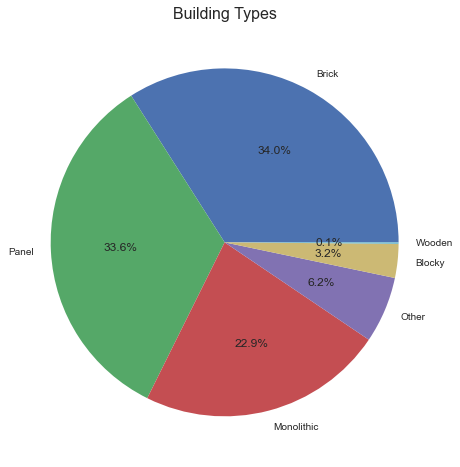

In [13]:
# Let's see the building types proportion (wall matherial)

building_types = df_real['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Building Types')
plt.show()

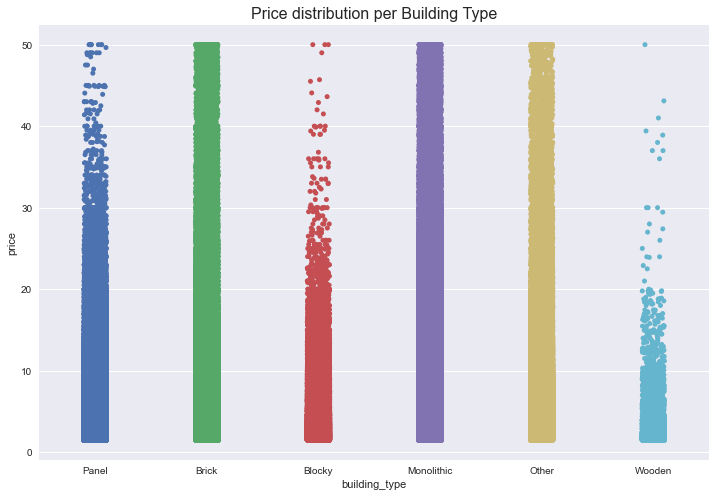

In [51]:
# price distribution depending on building (wall) types

sns.stripplot(x='building_type',y='price',data=df_real)
plt.title('Price distribution per Building Type')
plt.show()

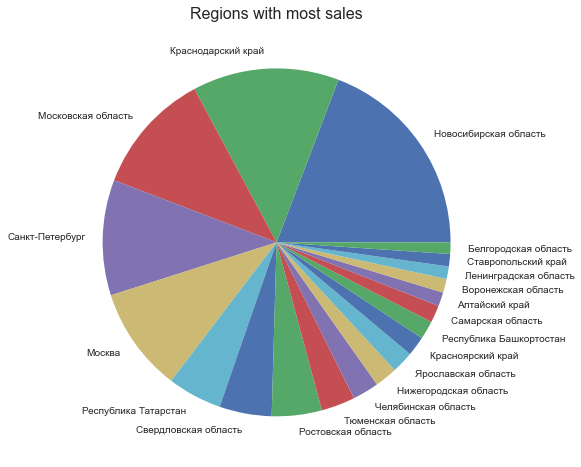

In [16]:
# let's visualize the distribution of sales by region over the whole period

df_real['region_name'].value_counts().head(20).plot(kind='pie',stacked=True);
plt.title("Regions with most sales")
plt.ylabel('')
plt.show()

In [17]:
# to plot price changes over time we need to select spesific regions to compare (out of 84 regions)
# let's hardcode two region codes in the function select_region

def select_region(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['region'] == 3) | (df['region'] == 2661)]
    return df

In [18]:
# now we can filter out regions using our function and store the results in separate dataframe df_region

df_region = df_real.pipe(select_region)

In [19]:
df_region.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,6.0500,2018-02-19,59.8058,30.3761,2661,Panel,8,10,3,82.6000,10.8000,Secondary Real Estate,Санкт-Петербург
6,4.7043,2018-03-04,55.6211,37.4310,3,Monolithic,1,25,1,31.7000,6.0000,New Building,Москва
7,3.6000,2018-03-04,59.8755,30.3955,2661,Panel,2,5,1,31.1000,6.0000,Secondary Real Estate,Санкт-Петербург
20,8.0000,2018-03-17,55.7389,37.8254,3,Panel,5,9,2,45.0000,6.0000,Secondary Real Estate,Москва
29,11.5000,2018-04-03,55.7989,37.7381,3,Panel,14,16,3,64.9000,8.0000,Secondary Real Estate,Москва


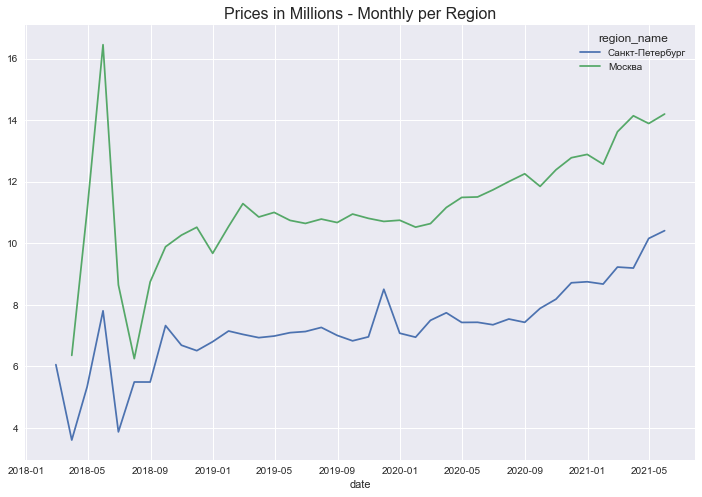

In [49]:
# now we can group the new dataset in order to draw the timeseries lineplot
# grouping by month and region_name, aggregation by average price

price_by_month = df_region.groupby(
    [pd.Grouper(key='date', freq='M'), 'region_name']
    ).agg('price').mean()

sns.lineplot(x='date', y=price_by_month.values, hue='region_name', data=price_by_month)
plt.title("Prices in Millions - Monthly per Region")
plt.show()

In [50]:
# we can wrap everything into the function compare_regions a and b

def compare_regions(a,b):
    def select_region(df: pd.DataFrame) -> pd.DataFrame:
        df = df[(df['region'] == a) | (df['region'] == b)]
        return df

    df_region = df_real.pipe(select_region)
    price_by_month = df_region.groupby(
        [pd.Grouper(key='date', freq='M'), 'region_name']
        ).agg('price').mean()

    sns.lineplot(x='date', y=price_by_month.values, hue='region_name', data=price_by_month)
    plt.title("Prices in Millions - Monthly per Region")
    return plt.show()

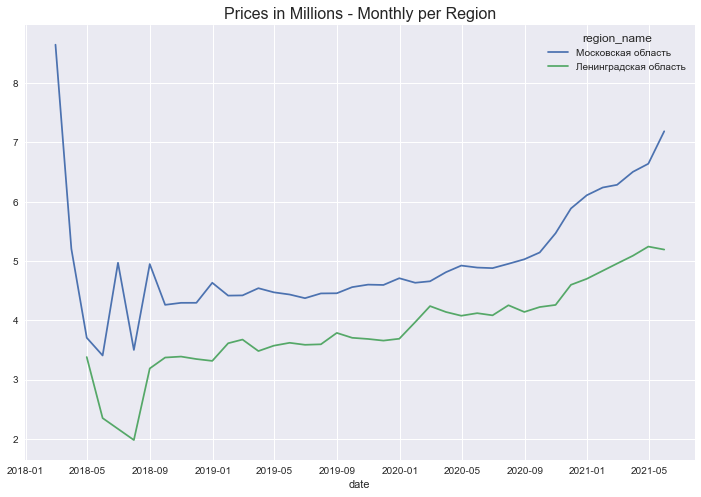

In [51]:
# and call it to draw a compasison chart (lineplot)

compare_regions(3446,81)

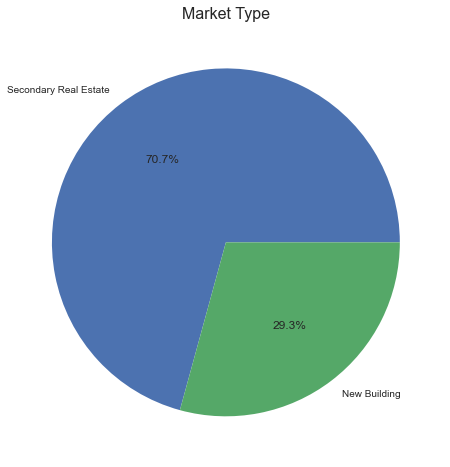

In [48]:
# now let's see the market type proportions

market_type = df_real['object_type'].value_counts()
plt.pie(market_type.values, labels=market_type.index, autopct='%1.1f%%')
plt.title('Market Type')
plt.show()

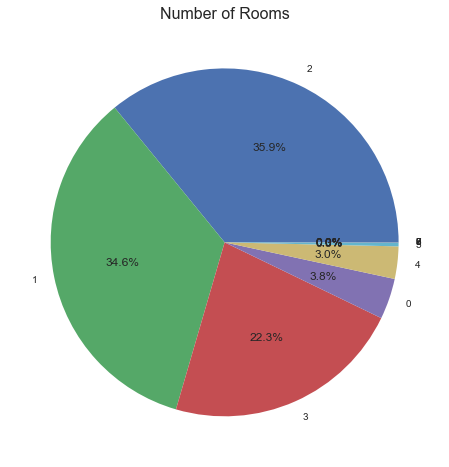

In [47]:
# number of rooms proportion

rooms = df_real['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Number of Rooms')
plt.show()

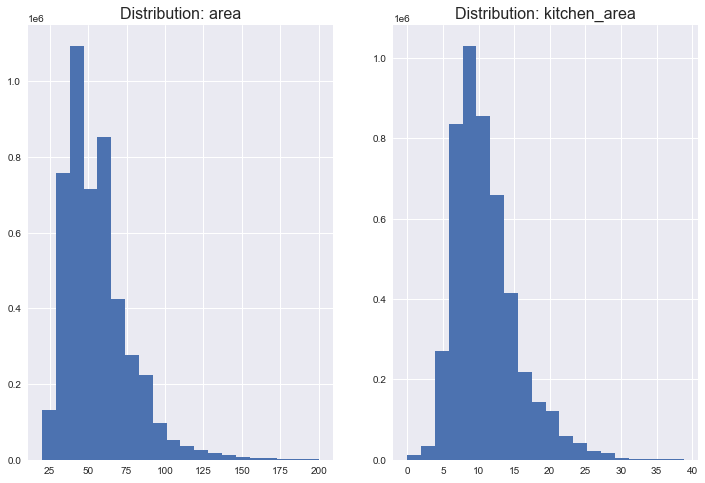

In [91]:
# area and kitchen_area distribution hist plot (continuous variables)

pos = 0
for pos, feature in enumerate(['area', 'kitchen_area']):
    sp = plt.subplot(1, 2, pos + 1)
    plt.hist(df_real[feature], bins=20)
    plt.title(f'Distribution: {feature}')
plt.show()

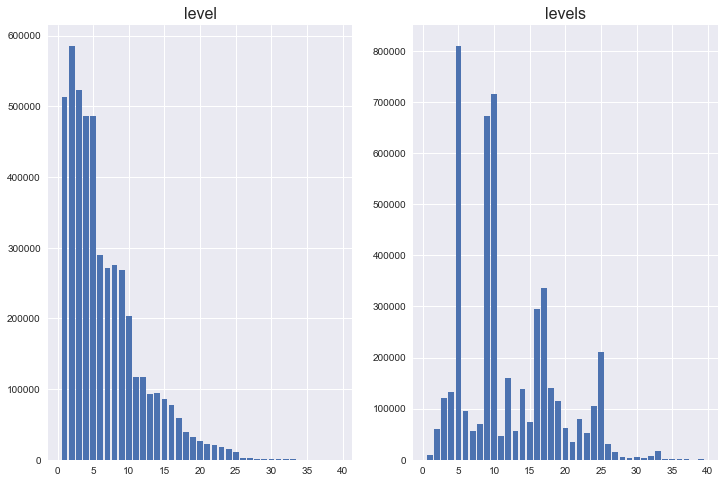

In [92]:
# level and levels distribution bar plot (categorical variables)

pos = 0
for pos, feature in enumerate(['level', 'levels']):
    levels = df_real[feature].value_counts()
    sp = plt.subplot(1, 2, pos + 1)
    plt.bar(levels.index, levels.values)
    plt.title(feature)
plt.show()

In [50]:
# To see average price per region we need to group by region_name

price_by_region = df_real.groupby('region_name').agg('price').mean().sort_values(ascending=False)

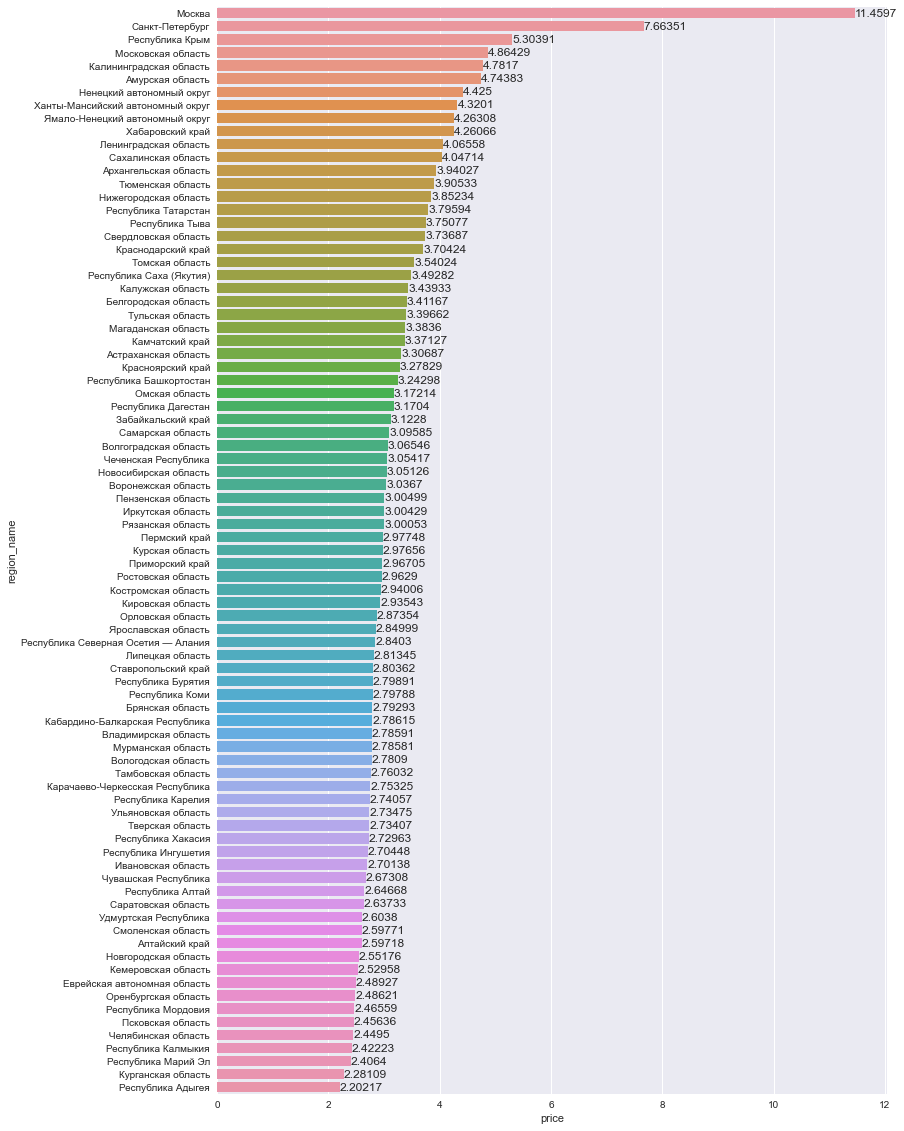

In [64]:
# now let's draw seaborn barchart with aggregated data

plt.rcParams['figure.figsize'] = 12, 20
ax = sns.barplot(x=price_by_region, y=price_by_region.index)
ax.bar_label(ax.containers[0])
plt.show()

# Conclusions

Considering all the EDA above it will be neccessary to conclude the following:
1. Brick, Panel and Monolitic constructions are >90% of the dataset
2. Price distribution vary significantly dependyng on building type
3. Top region are surprising and represent the most active regions in real estate market
4. New buildings are 30% and 70% is secondary market
5. We can visually estimathe the distribution of rooms, area and levels
6. The price-per-region vary a lot, Moscow and SPB are far leaders
7. Dataset was not cosistently collected over time (spikes in price)

Price prediction modeling requires data from homogeneous groups. In our case model should be built per region.
 + Additional regional and municipal data is required: Building information (construction year, heating type)
 + Infrastructure information (transport, shchools/daycare, shopping, parks nearby)
 + Data based on online ads in regions.